# Analyzing Podcasts

What does a great podcast sound like?

One of the many criteria is active engagements: fast exchange of speakers, creative discussions, and not minute-long, tedious talks.

Imagine you are a podcast creator and just finished a podcast with guests. How well did I do? Wouldn't it be nice to pump the podcast audio to an AI model, and the AI model, plus some data science magic, gives a visual representation of how things go? Are guests interacting in a meaningful way? Am I distributing time right? You might want to find these out quickly.

With the WhisperX model running on Lepton, it is easy to build applications to understand such problems easily. With each color meaning a different speaker, each row being a minute, which of the following two podcasts is more engaging, and plausibly higher quality?

<img src="assets/positive_example.png" width=300/><img src="assets/negative_example.png" width=230/>

Let's learn from positive examples by looking at one of my favorite podcast episodes, from 99 Percent Invisible. We'll use the speech recognition model Whisper + speaker diarization algorithm to do voice recognition, produce transcripts, and produce the conversation visualization like above.

Disclaimer: This is only an illustrative example of how voice recognition and speaker diarization work. The copyright of the episode belongs to the original authors.

In [1]:
# First, let's download to the current folder.
! wget https://99percentinvisible.org/episode/stuccoed-in-time/download --quiet -O stuccoed_in_time.mp3

Now, we will use the whisperx example in this folder to do the work. Let's assume that you already have a lepton account and have logged in (if not, do `lep login` in your favorite commandline interface). Let's first start the whisperx model. For this, we will need a reasonably powerful gpu, like a T4.

In [2]:
# Remember to replace the token with your own!
!lep photon create -n whisperx -m main.py
!lep photon push -n whisperx
!lep secret create -n HUGGING_FACE_HUB_TOKEN -v hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
!lep photon run -n whisperx -dn whisperx --resource-shape gpu.t4 --secret HUGGING_FACE_HUB_TOKEN

Photon whisperx created.
Photon whisperx pushed to workspace.
Secret with name HUGGING_FACE_HUB_TOKEN already exists. Please use a different 
name or remove the existing secret with `lep secret remove` first.
Running the most recent version of whisperx: whisperx-68tdh8rf
Photon launched as whisperx. Use `lep deployment status -n whisperx` to check 
the status.


Let's check if the deployment has started. We can use the CLI to do so. Run this a few times till the status shows "Running". You can also use the Web UI url to do so.

In [4]:
!lep deployment status -n whisperx

Time now:   2023-09-13 09:00:00
Created at: 2023-09-13 08:51:21
Photon ID:  whisperx-68tdh8rf
State:      Running
Web UI:     
https://dashboard.lepton.ai/workspace/jazwwwt0/deployments/detail/whisperx/demo
Is Public:  No
Replicas List:
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ replica id                ┃ status ┃ message ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ whisperx-7878d459b7-mxlt4 │ Ready  │ (empty) │
└───────────────────────────┴────────┴─────────┘
1 out of 1 replicas ready.


Now that the remote service has started, let's run our local data analytics. You don't need to have a beefy GPU - that is the beautiful part. The GPU lives in the cloud.

Let's first inspect the main function that we are going to use - `run` - that sends an audio to the cloud and does transcriptions and other analysis.

In [5]:
from leptonai.client import Client, current
from leptonai.photon import FileParam

# When you are logged into your own workspace, current() automatically
# fills in the workspace name and token for you.
c = Client(current(), "whisperx")
print("Exposed paths from the client are:")
print(list(c.paths()))
print("Documentation for run is:")
help(c.run)

Exposed paths from the client are:
['/get_result', '/run', '/status']
Documentation for run is:
Help on function /run in module leptonai.client:

/run(*args, **kwargs)
    Runs transcription, alignment, and diarization for the input.
    
    - Inputs:
        - input: a url containing the audio file, or a base64-encoded string containing an
            audio file, or a lepton.photon.FileParam, or a local file path if running
            locally.
        - language(optional): the language code for the input. If not provided, the model
            will try to detect the language automatically (note this runs more slowly)
        - min_speakers(optional): the hint for minimum number of speakers for diarization.
        - max_speakers(optional): the hint for maximum number of speakers for diarization.
        - transcribe_only(optional): if True, only transcribe the audio, and skip alignment
            and diarization.
    
    - Returns:
        - result: if the input audio is less than

In [6]:
# Let's run the task, and then I'll explain more details.
task_id = c.run(input=FileParam(open("stuccoed_in_time.mp3", "rb")), language="en")

Basically, when we are running large recognition tasks, in this case a 45 minute audio conversation, it will take quite some time to finish. As a result, it's better to not have the underlying http request long-waiting, and it's better to finish the file upload, return a task id, and then the client side can regularly check back to see if the task finished. This is exactly how our WhisperX background-task mode server is. You can refer to the code for more details.

Let's inspect the task id, which is a simple UUID:

In [7]:
print(task_id)

{'task_id': '432a4c6c-3696-4f45-a9e7-272600425b35'}


Let's implement a simple waiting strategy: call `status`, and if the status is not ready, wait for progressively long time until the status says "OK".

In [8]:
import time

wait_time = 1 # in seconds
while c.status(**task_id)['status'] != "ok":
    time.sleep(wait_time)
    wait_time *= 2
    if wait_time > 60 * 20:
        # If the wait time is larger than 20 minutes, something is wrong.
        print("Hmm. Something is wrong.")
        break
else:
    print(c.status(**task_id))
    result = c.get_result(**task_id)

{'status': 'ok'}


It's a near hour long audio, patience is a virtue, but we'll get the results.

In [9]:
num_speakers = len(set([r["speaker"] for r in result]))
print(f"Number of speakers: {num_speakers}")

Number of speakers: 12


Let's print the conversations to take a look.

In [10]:
def format_seconds(seconds):
    minutes = int(seconds // 60)
    seconds_remainder = int(seconds % 60)
    formatted_time = f"{minutes}'{seconds_remainder}\""
    return formatted_time

for r in result:
    start = format_seconds(r['start'])
    end = format_seconds(r['end'])
    print(f"{r['speaker']} ({start}-{end}): {r['text'].strip()}")

SPEAKER_03 (0'0"-0'2"): This is 99% Invisible.
SPEAKER_03 (0'2"-0'5"): I'm Roman Mars.
SPEAKER_03 (0'5"-0'18"): Back in the early 2000s, an architect named Trey Jordan wrote a letter to Santa Fe, New Mexico's Historic Preservation Division, laying out the details of a house he was hoping to build in the city's historic district.
SPEAKER_03 (0'18"-0'20"): The process started out pretty normal.
SPEAKER_02 (0'20"-0'24"): We were just not ready for what happened.
SPEAKER_02 (0'24"-0'28"): I mean, I don't remember the process being that thorny.
SPEAKER_03 (0'28"-0'35"): The first indication that things maybe wouldn't go smoothly had to do with the color of the stucco that Trey wanted to use.
SPEAKER_02 (0'35"-0'37"): I do recall that in my proposal letter,
SPEAKER_02 (0'38"-0'51"): I had mentioned that the stucco color would be a custom color similar to, I think it was cottonwood, which is its standard color of a commercially available stucco.
SPEAKER_07 (0'51"-0'59"): Buildings in the Hist

In [11]:
speakers = set([r["speaker"] for r in result])
print(f"Number of classified speakers: {len(speakers)}")

Number of classified speakers: 12


Of course, the model doesn't take care of the physical names of the speakers - we can possibly put this into an LLM to ground the speakers to the names mentioned in the text, but that's story for another day. During this demo, we have manually looked and identified the following speaker names:

In [12]:
speaker_names = {
    "SPEAKER_00": "FROM NEWS CLIP",
    "SPEAKER_01": "FROM NEWS CLIP",
    "SPEAKER_02": "Trey Jordan",
    "SPEAKER_03": "Roman Mars",
    "SPEAKER_04": "FROM NEWS CLIP",
    "SPEAKER_05": "Roxanne Swentzell",
    "SPEAKER_06": "Joseph Montoya",
    "SPEAKER_07": "Delaney Hall",
    "SPEAKER_08": "Lisa Gavioli Roach",
    "SPEAKER_09": "Ray Herrera",
    "SPEAKER_10": "Chris Wilson",
    "SPEAKER_11": "FROM NEWS CLIP",
}
real_speakers = set(speaker_names.values())

When a speaker speaks for a long time, the model might chunk it to different segments. To show the whole conversation in a more meaningful way, let's combine segments of the same speaker, and display the conversation.

In [13]:
# Let's combine the entries.
import copy

def combine_same_speaker(result):
    combined = [copy.copy(result[0])]
    for r in result[1:]:
        if r['speaker'] == combined[-1]['speaker']:
            combined[-1]['end'] = r['end']
            combined[-1]['text'] += " " + r['text'].strip()
            combined[-1]['words'] += r['words']
        else:
            # Note: don't add r directly. Do a copy.
            combined.append(copy.copy(r))
    return combined

combined = combine_same_speaker(result)
for r in combined:
    start = format_seconds(r['start'])
    end = format_seconds(r['end'])
    print(f"{speaker_names[r['speaker']]} ({start}-{end}): {r['text'].strip()}\n")

Roman Mars (0'0"-0'20"): This is 99% Invisible. I'm Roman Mars. Back in the early 2000s, an architect named Trey Jordan wrote a letter to Santa Fe, New Mexico's Historic Preservation Division, laying out the details of a house he was hoping to build in the city's historic district. The process started out pretty normal.

Trey Jordan (0'20"-0'28"): We were just not ready for what happened. I mean, I don't remember the process being that thorny.

Roman Mars (0'28"-0'35"): The first indication that things maybe wouldn't go smoothly had to do with the color of the stucco that Trey wanted to use.

Trey Jordan (0'35"-0'51"): I do recall that in my proposal letter, I had mentioned that the stucco color would be a custom color similar to, I think it was cottonwood, which is its standard color of a commercially available stucco.

Delaney Hall (0'51"-0'59"): Buildings in the Historic District have to follow a number of design guidelines so that they fit in with Santa Fe's traditional Adobe look.

Now, how do the interactions look like? Are the host and guests engaging in active conversations? One thing we can do is to print out a second-by-second conversation history, and visualize the whole 45-minute conversation as an image. Let's do that. If you are a python matplotlib fan, read the following code; otherwise, you can safely jump over and look at the generated image directly.

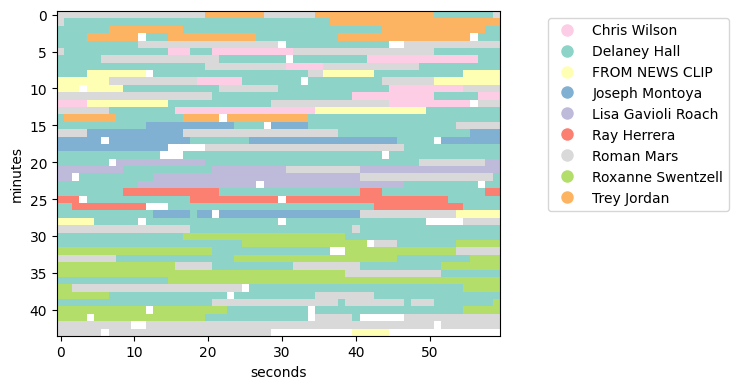

In [22]:
# Let's draw out the speaker map.
# Create a grid layout with two columns
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import gridspec
import numpy as np
import random

def generate_colors(num_colors):
    colormap = colormaps["Set3"]
    pastel_colors = [colormap(i) for i in range(num_colors)]
    random.shuffle(pastel_colors)
    return pastel_colors

color_map = {
    s:c[:3] for s, c in zip(real_speakers, generate_colors(len(real_speakers)))
}



total_time = int(combined[-1]['end'] // 60 + 1) * 60
colored_timelapse = np.ones((total_time, 3))
for r in result:
    start = int(r['start'])
    end = int(r['end'] + 0.5)
    colored_timelapse[start:end] = color_map[speaker_names[r['speaker']]]
    
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# Add the image to the left grid cell
ax_image = plt.subplot(gs[0])
ax_image.imshow(colored_timelapse.reshape((total_time//60, 60,3)))
plt.xlabel("seconds")
plt.ylabel("minutes")

# Add the legend to the right grid cell
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=speaker, 
                             markersize=10, markerfacecolor=color)
                  for speaker, color in sorted(color_map.items(), key=lambda x: x[0])]
ax_legend = plt.subplot(gs[1])
ax_legend.legend(handles=legend_patches, loc='upper left')
ax_legend.axis('off')

plt.tight_layout()

# Display the figure
plt.show()

To read the above figure: every horizontal row represents 60 seconds of a minute, and there are 43 rows representing 43 minutes' time. Every color represents a speaker: for example, for the first minute, you see Roman Mars speaking for about 20 seconds, then Trey Jordan, then Roman, then Trey, and then Delaney Hall. White space shows pauses where no one speaks.

A few observations from the color map:
- Roman Mars opens and ends the conversation as the host.
- Denaley Hall co-hosts the converation, and speaks most frequently - connecting the dots among guests.
- Trey joins the first part of the conversation; Chris joins later; Joseph, Lisa and Ray engages the conversation between 15' and 30'. After the break around 29', Roxanne and Delaney had an in-depth discussion for about 10 minutes, before the conversation comes to conclusion.

Overall the audiences had a very active engagement - lots of discussions, and also in-depth statements especially in the second half of the conversation.

Back to our technical story - it used to be difficult to have custom AI models deployed easily, and data scientists need to spend a lot of time dealing with infra before interesting work like conversation analysis can begin. Lepton aims to change this.

# Conclusion

Speech recognition and speech diarization are common techniques in the speech field. Combining these AI algorithms with a bit of data science could give us interesting insights into our multimedia data. 

We want AI algorithms and applications to be customizable, highly efficient, and easy to use. Let us know what you think! Feel free to ping us at [info@lepton.ai](mailto:info@lepton.ai) any time.

In [ ]:
# Let's close the service after done.
!lep deployment remove -n whisperx
